### Welcome to the backend experimentation notebook

This notebook makes use of the clean data produced by the cleaning experimentation notebook to come up with a clustering algorithm that can be turned into the modular cluster file.

In [2]:
# importing everything
import numpy as np
import pandas as pd
import sklearn as sl
import folium as fl
import csv
import datetime as dt
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('datasets/crimedata2016.csv')
df.head()

,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,FBI Code,X Coordinate,Y Coordinate,Year,Location,Latitude,Longitude
0,05/03/2016 11:40:00 PM,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,1022,08B,1154907.0,1893681.0,2016,"[41.864073157, -87.706818608]",41.864073,-87.706819
1,05/03/2016 09:40:00 PM,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,313,08B,1183066.0,1864330.0,2016,"[41.782921527, -87.60436317]",41.782922,-87.604363
2,05/03/2016 11:31:00 PM,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,False,1524,24,1140789.0,1904819.0,2016,"[41.894908283, -87.758371958]",41.894908,-87.758372
3,05/03/2016 10:10:00 PM,BATTERY,SIMPLE,SIDEWALK,False,False,1532,08B,1143223.0,1901475.0,2016,"[41.885686845, -87.749515983]",41.885687,-87.749516
4,05/03/2016 10:00:00 PM,THEFT,$500 AND UNDER,RESIDENCE,False,True,1523,06,1139890.0,1901675.0,2016,"[41.886297242, -87.761750709]",41.886297,-87.761751


In [4]:
timelist = []
for i in range(len(df)):
    datetime_object = dt.datetime.strptime(df['Date'][i][-11:], '%I:%M:%S %p')
    timelist.append(datetime_object)
df['Time'] = timelist
df.head()

,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,FBI Code,X Coordinate,Y Coordinate,Year,Location,Latitude,Longitude,Time
0,05/03/2016 11:40:00 PM,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,1022,08B,1154907.0,1893681.0,2016,"[41.864073157, -87.706818608]",41.864073,-87.706819,1900-01-01 23:40:00
1,05/03/2016 09:40:00 PM,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,313,08B,1183066.0,1864330.0,2016,"[41.782921527, -87.60436317]",41.782922,-87.604363,1900-01-01 21:40:00
2,05/03/2016 11:31:00 PM,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,False,1524,24,1140789.0,1904819.0,2016,"[41.894908283, -87.758371958]",41.894908,-87.758372,1900-01-01 23:31:00
3,05/03/2016 10:10:00 PM,BATTERY,SIMPLE,SIDEWALK,False,False,1532,08B,1143223.0,1901475.0,2016,"[41.885686845, -87.749515983]",41.885687,-87.749516,1900-01-01 22:10:00
4,05/03/2016 10:00:00 PM,THEFT,$500 AND UNDER,RESIDENCE,False,True,1523,06,1139890.0,1901675.0,2016,"[41.886297242, -87.761750709]",41.886297,-87.761751,1900-01-01 22:00:00


In [5]:
cleandf = df.drop(['Date', 'X Coordinate', 'Y Coordinate', 'Beat', 'Year', 'FBI Code'], axis=1)
cleandf.head()

,Primary Type,Description,Location Description,Arrest,Domestic,Location,Latitude,Longitude,Time
0,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,"[41.864073157, -87.706818608]",41.864073,-87.706819,1900-01-01 23:40:00
1,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,"[41.782921527, -87.60436317]",41.782922,-87.604363,1900-01-01 21:40:00
2,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,False,"[41.894908283, -87.758371958]",41.894908,-87.758372,1900-01-01 23:31:00
3,BATTERY,SIMPLE,SIDEWALK,False,False,"[41.885686845, -87.749515983]",41.885687,-87.749516,1900-01-01 22:10:00
4,THEFT,$500 AND UNDER,RESIDENCE,False,True,"[41.886297242, -87.761750709]",41.886297,-87.761751,1900-01-01 22:00:00


In [6]:
# using sklearn's label encoder for more complex encoders where severity isn't needed
from sklearn import preprocessing as pp
lp = pp.LabelEncoder()
op = pp.OrdinalEncoder()
# creating a manual encoder for descriptions
basicCrime = list(set(cleandf['Primary Type']))
basicCrime

['CRIMINAL DAMAGE',
 'ARSON',
 'OBSCENITY',
 'ASSAULT',
 'MOTOR VEHICLE THEFT',
 'CONCEALED CARRY LICENSE VIOLATION',
 'NON - CRIMINAL',
 'HUMAN TRAFFICKING',
 'OFFENSE INVOLVING CHILDREN',
 'CRIMINAL TRESPASS',
 'NON-CRIMINAL',
 'PUBLIC PEACE VIOLATION',
 'WEAPONS VIOLATION',
 'BATTERY',
 'CRIM SEXUAL ASSAULT',
 'PUBLIC INDECENCY',
 'SEX OFFENSE',
 'INTIMIDATION',
 'OTHER OFFENSE',
 'GAMBLING',
 'DECEPTIVE PRACTICE',
 'LIQUOR LAW VIOLATION',
 'INTERFERENCE WITH PUBLIC OFFICER',
 'OTHER NARCOTIC VIOLATION',
 'ROBBERY',
 'NON-CRIMINAL (SUBJECT SPECIFIED)',
 'NARCOTICS',
 'THEFT',
 'BURGLARY',
 'KIDNAPPING',
 'STALKING',
 'PROSTITUTION',
 'HOMICIDE']

In [7]:
primList = {'NON - CRIMINAL': 0, 'NON-CRIMINAL (SUBJECT SPECIFIED)': 0, 'NON-CRIMINAL': 0,
            'INTIMIDATION': 1, 'OBSCENITY': 1, 'OTHER OFFENSE': 1, 'PUBLIC INDECENCY': 1,
            'LIQUOR LAW VIOLATION': 2, 'PUBLIC PEACE VIOLATION': 2, 'CONCEALED CARRY LICENSE VIOLATION': 2,
            'PROSTITUTION': 3, 'GAMBLING': 3, 'INTERFERENCE WITH PUBLIC OFFICER': 3, 'STALKING': 3,
            'ARSON': 6, 'BURGLARY': 5, 'BATTERY': 2, 'ROBBERY': 5, 'SEX OFFENSE': 5, 'ASSAULT': 3,
            'THEFT': 4, 'DECEPTIVE PRACTICE': 5, 'CRIMINAL TRESPASS': 4, 'CRIMINAL DAMAGE': 4, 'WEAPONS VIOLATION' : 5,
            'MOTOR VEHICLE THEFT': 5, 'OFFENSE INVOLVING CHILDREN': 5, 'KIDNAPPING': 5, 'NARCOTICS': 5,
            'OTHER NARCOTIC VIOLATION' : 4,'HUMAN TRAFFICKING' : 6,'CRIM SEXUAL ASSAULT' : 6, 'HOMICIDE' : 6}
len(primList)

33

In [41]:
encodePrim = [primList[i] for i in cleandf['Primary Type']]
cleandf['desc'] = lp.fit_transform(cleandf['Description'])
cleandf['locdesc'] = lp.fit_transform(cleandf['Location Description'])
cleandf['type'] = encodePrim
cleandf.head()

,Primary Type,Description,Location Description,Arrest,Domestic,Location,Latitude,Longitude,Time,type,desc,locdesc
0,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,"[41.864073157, -87.706818608]",41.864073,-87.706819,1900-01-01 23:40:00,2,104,17
1,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,"[41.782921527, -87.60436317]",41.782922,-87.604363,1900-01-01 21:40:00,2,104,99
2,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,False,"[41.894908283, -87.758371958]",41.894908,-87.758372,1900-01-01 23:31:00,2,234,114
3,BATTERY,SIMPLE,SIDEWALK,False,False,"[41.885686845, -87.749515983]",41.885687,-87.749516,1900-01-01 22:10:00,2,251,111
4,THEFT,$500 AND UNDER,RESIDENCE,False,True,"[41.886297242, -87.761750709]",41.886297,-87.761751,1900-01-01 22:00:00,4,0,99


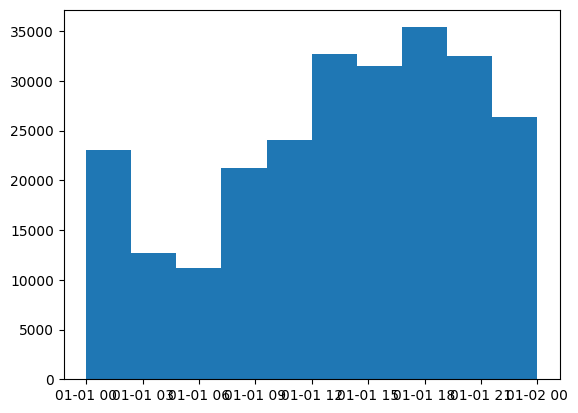

In [9]:
plt.hist(cleandf['Time'])
plt.show()

In [10]:
from collections import Counter
count = Counter(cleandf['Location'])

In [27]:
import plotly.express as px
fig = px.density_mapbox(cleandf, lat='Latitude', lon='Longitude', z='type',
                        mapbox_style="stamen-terrain", radius=1, width=650, height=650)
# fig                    

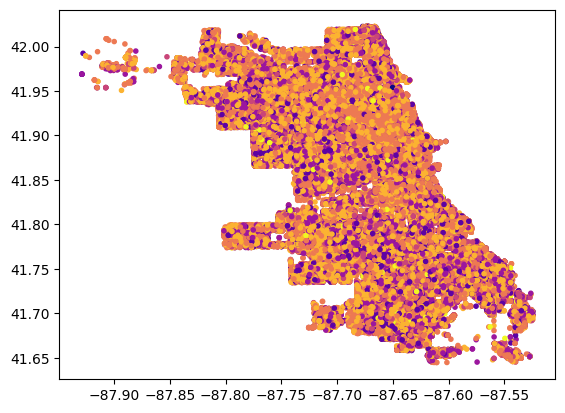

In [12]:
colormap = {0 : '#0d0887', 1 : '#5d02a4', 2 : '#9b169e', 3 : '#c94579', 
            4 : '#ed7953', 5 : '#fcb331', 6 : '#f0f821'}
plt.scatter(cleandf['Longitude'], cleandf['Latitude'], marker='.', 
            c=[colormap[i] for i in cleandf['type']])
plt.show()

In [42]:
# DO NOT RUN THIS, filtered dataset saver

# f = open('datasets/plotset.csv', 'w')
# writer = csv.writer(f)
# writer.writerow(list(cleandf.columns))
# for i in range(len(cleandf)):
#     writer.writerow(cleandf.iloc[i])
# f.close()

Now we learn how to make clusters just based on the number of clusters required

In [40]:
# making a time filter
def timeFilter(start: str, end: str) -> pd.DataFrame:
    start = dt.datetime.strptime(start, '%H:%M:%S')
    end = dt.datetime.strptime(end, '%H:%M:%S')
    if (start < end):
        return cleandf.loc[(df['Time'] >= start) & (df['Time'] < end)]
    else:
        return cleandf.loc[(df['Time'] >= start) | (df['Time'] < end)]

# examplse of if
ifs = timeFilter('17:00:00', '09:00:00')
# example of else
els = timeFilter('09:00:00','17:00:00')
# check to see if we cover everything
len(ifs) + len(els) == len(cleandf)

True

In [15]:
from sklearn.cluster import *